# peak localization in spikeinterface

spikeinterface include several methods for unit or peak localization :

  * **'center_of_mass'** : classic and fast localization. For instance herdingspikes use this method.
    It is quite accurate on squared MEA but have string artifact when units are on the border of the probe.
    So for linear probe this method give poor result on X axis.
  * **'monopolar_triangulation'** with optimizer='least_square'
    This method is from Julien Boussard and Erdem Varol from the Paninski lab.
    This has been presented at [NeurIPS](https://slideslive.com/38968886/threedimensional-spike-localization-and-improved-motion-correction-for-neuropixels-recordings?ref=recommended)
    see also [here](https://openreview.net/forum?id=ohfi44BZPC4)
  * **'monopolar_triangulation'** with optimizer='minimize_with_log_penality'
    It is an improvement from the same team on the previous method not publish yet.



Here an example how to use.

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import spikeinterface.full as si

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 12)



In [5]:
# local folder
base_folder = Path('/mnt/data/sam/DataSpikeSorting/imposed_motion_nick')

dataset_folder = base_folder / 'dataset1/NP1'
preprocess_folder = base_folder / 'dataset1_NP1_preprocessed'
peak_folder = base_folder / 'dataset1_NP1_peaks'

peak_folder.mkdir(exist_ok=True)

In [6]:
# global kwargs for parallel computing
job_kwargs = dict(
    n_jobs=40,
    chunk_duration='1s',
    progress_bar=True,
)

In [11]:
# read the file
rec = si.read_spikeglx(dataset_folder)
rec

SpikeGLXRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 1957.191s

(-150.0, 200.0)

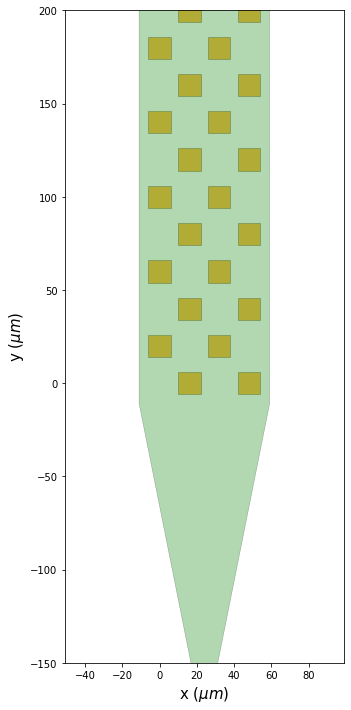

In [12]:
fig, ax = plt.subplots()
si.plot_probe_map(rec, ax=ax)
ax.set_ylim(-150, 200)

## preprocess

This take 4 min for 30min of signals

In [13]:
if not preprocess_folder.exists():
    rec_filtered = si.bandpass_filter(rec, freq_min=300., freq_max=6000.)
    rec_preprocessed = si.common_reference(rec_filtered, reference='global', operator='median')
    rec_preprocessed.save(folder=preprocess_folder, **job_kwargs)
rec_preprocessed = si.load_extractor(preprocess_folder)

write_binary_recording with n_jobs 40  chunk_size 30000


write_binary_recording: 100%|██████████| 1958/1958 [03:09<00:00, 10.34it/s]


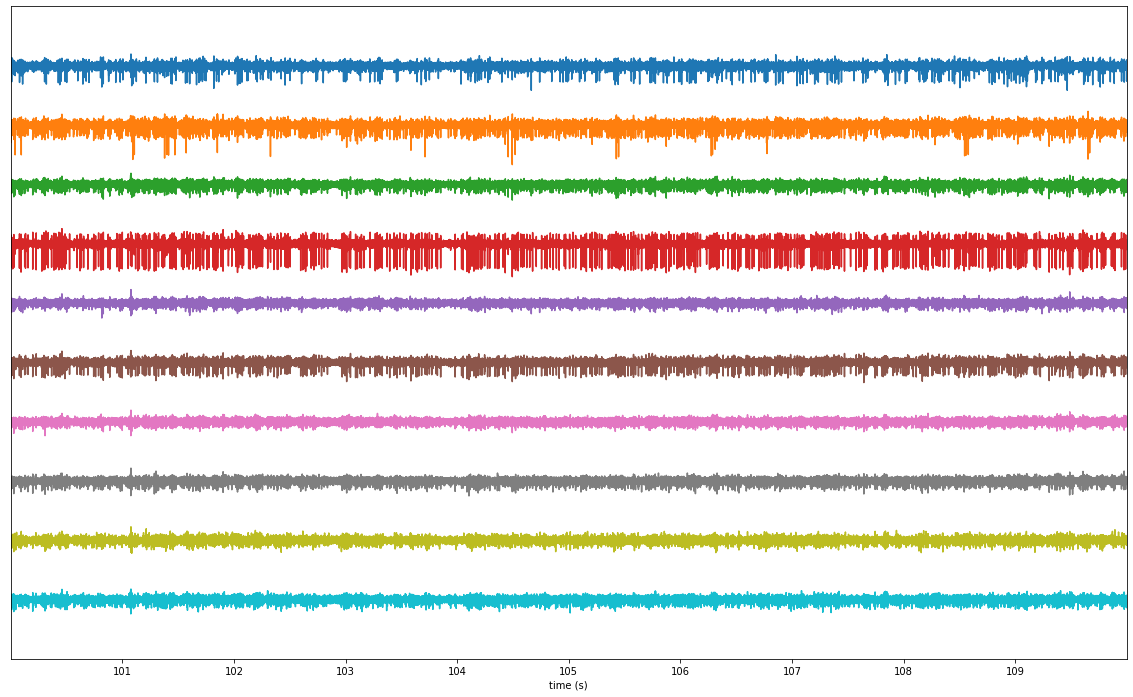

In [14]:
# plot and check spikes
si.plot_timeseries(rec_preprocessed, time_range=(100, 110), channel_ids=rec.channel_ids[50:60])

## estimate noise

Text(0.5, 1.0, 'noise across channel')

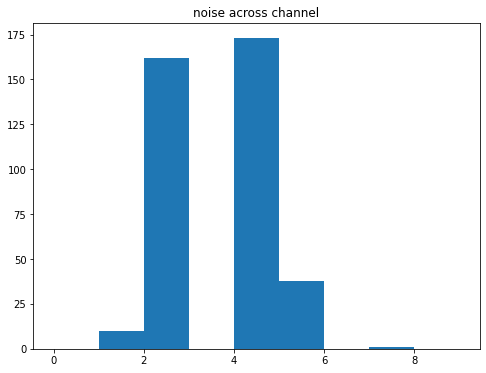

In [15]:
noise_levels = si.get_noise_levels(rec_preprocessed, return_scaled=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(noise_levels, bins=np.arange(0,10, 1))
ax.set_title('noise across channel')

## detect peaks

This take 1min10s

In [16]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

In [18]:
if not (peak_folder / 'peaks.npy').exists():
    peaks = detect_peaks(
        rec_preprocessed,
        method='locally_exclusive',
        local_radius_um=100,
        peak_sign='neg',
        detect_threshold=5,
        n_shifts=5,
        noise_levels=noise_levels,
        **job_kwargs,
    )
    np.save(peak_folder / 'peaks.npy', peaks)
peaks = np.load(peak_folder / 'peaks.npy')
print(peaks.shape)

detect peaks: 100%|██████████| 1958/1958 [01:11<00:00, 27.26it/s]


(4041179,)


## localize peaks

We use 2 methods:
  * 'center_of_mass': 9 s
  * 'monopolar_triangulation' leagacy : 26min
  * 'monopolar_triangulation' log barrier : 16min

In [19]:
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

In [21]:
if not (peak_folder / 'peak_locations_center_of_mass.npy').exists():
    peak_locations = localize_peaks(
        rec_preprocessed,
        peaks,
        ms_before=0.3,
        ms_after=0.6,
        method='center_of_mass',
        method_kwargs={'local_radius_um': 100.},
        **job_kwargs,
    )
    np.save(peak_folder / 'peak_locations_center_of_mass.npy', peak_locations)
    print(peak_locations.shape)


localize peaks: 100%|██████████| 1958/1958 [00:08<00:00, 218.72it/s]


(4041179,)


In [36]:
if not (peak_folder / 'peak_locations_monopolar_triangulation_legacy.npy').exists():
    peak_locations = localize_peaks(
        rec_preprocessed,
        peaks,
        ms_before=0.3,
        ms_after=0.6,
        method='monopolar_triangulation',
        method_kwargs={'local_radius_um': 100., 'max_distance_um': 1000., 'optimizer': 'least_square'},
        **job_kwargs,
    )
    np.save(peak_folder / 'peak_locations_monopolar_triangulation_legacy.npy', peak_locations)
    print(peak_locations.shape)

localize peaks: 100%|██████████| 1958/1958 [26:42<00:00,  1.22it/s] 


(4041179,)


In [23]:
if not (peak_folder / 'peak_locations_monopolar_triangulation_log_limit.npy').exists():
    peak_locations = localize_peaks(
        rec_preprocessed,
        peaks,
        ms_before=0.3,
        ms_after=0.6,
        method='monopolar_triangulation',
        method_kwargs={'local_radius_um': 100., 'max_distance_um': 1000., 'optimizer': 'minimize_with_log_penality'},
        **job_kwargs,
    )
    np.save(peak_folder / 'peak_locations_monopolar_triangulation_log_limit.npy', peak_locations)
    print(peak_locations.shape)

localize peaks: 100%|██████████| 1958/1958 [16:15<00:00,  2.01it/s]


(4041179,)


In [24]:
# load back
# peak_locations = np.load(peak_folder / 'peak_locations_center_of_mass.npy')
# peak_locations = np.load(peak_folder / 'peak_locations_monopolar_triangulation_legacy.npy')
peak_locations = np.load(peak_folder / 'peak_locations_monopolar_triangulation_log_limit.npy')
print(peak_locations)

[( 18.81849235, 1782.84538913,  78.17532357, 1696.96239445)
 ( 31.90279769, 3847.75061369, 134.79844077, 1716.03155721)
 (-23.12038001, 2632.87834759,  87.76916268, 2633.62546695) ...
 ( 40.0839554 , 1977.83852796,  26.50998809, 1092.53885299)
 (-51.40036701, 1772.34521905, 170.65660676, 2533.03617278)
 ( 54.3813594 , 1182.28971165,  87.35020554, 1303.53392431)]


## plot on probe

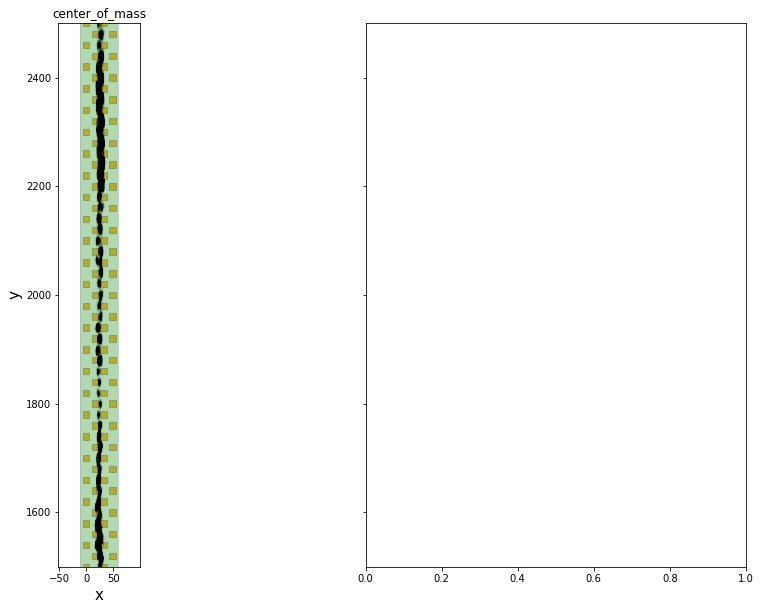

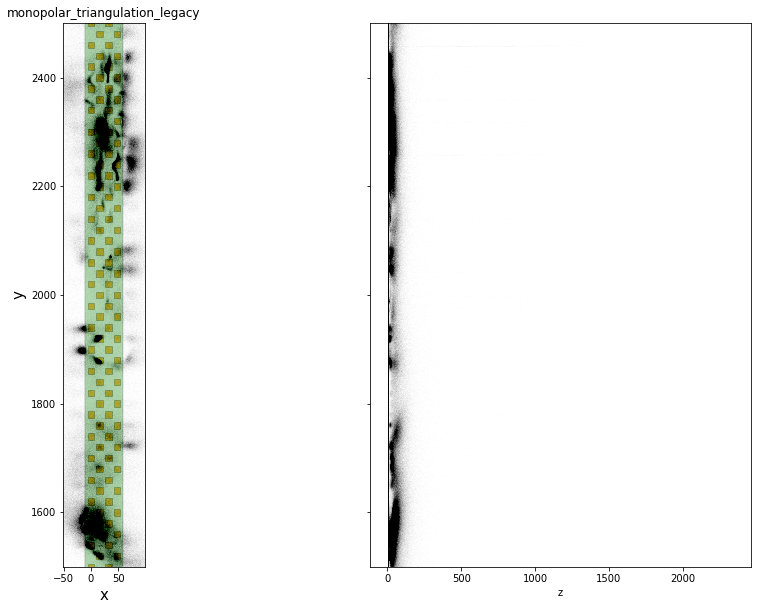

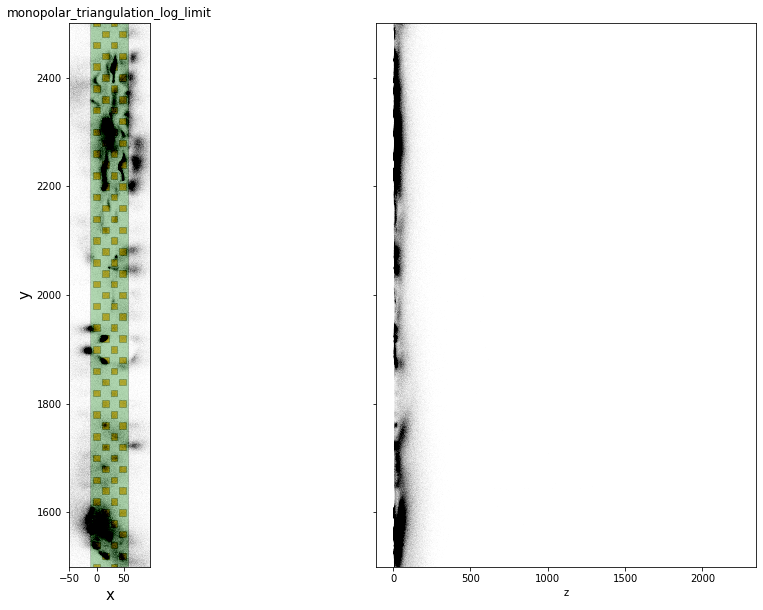

In [38]:
for name in ('center_of_mass', 'monopolar_triangulation_legacy', 'monopolar_triangulation_log_limit'):

    peak_locations = np.load(peak_folder / f'peak_locations_{name}.npy')

    probe = rec_preprocessed.get_probe()

    fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(15, 10))
    ax = axs[0]
    plot_probe(probe, ax=ax)
    ax.scatter(peak_locations['x'], peak_locations['y'], color='k', s=1, alpha=0.002)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(name)
    if 'z' in peak_locations.dtype.fields:
        ax = axs[1]
        ax.scatter(peak_locations['z'], peak_locations['y'], color='k', s=1, alpha=0.002)
        ax.set_xlabel('z')
    ax.set_ylim(1500, 2500)

## plot peak depth vs time

(1300.0, 2500.0)

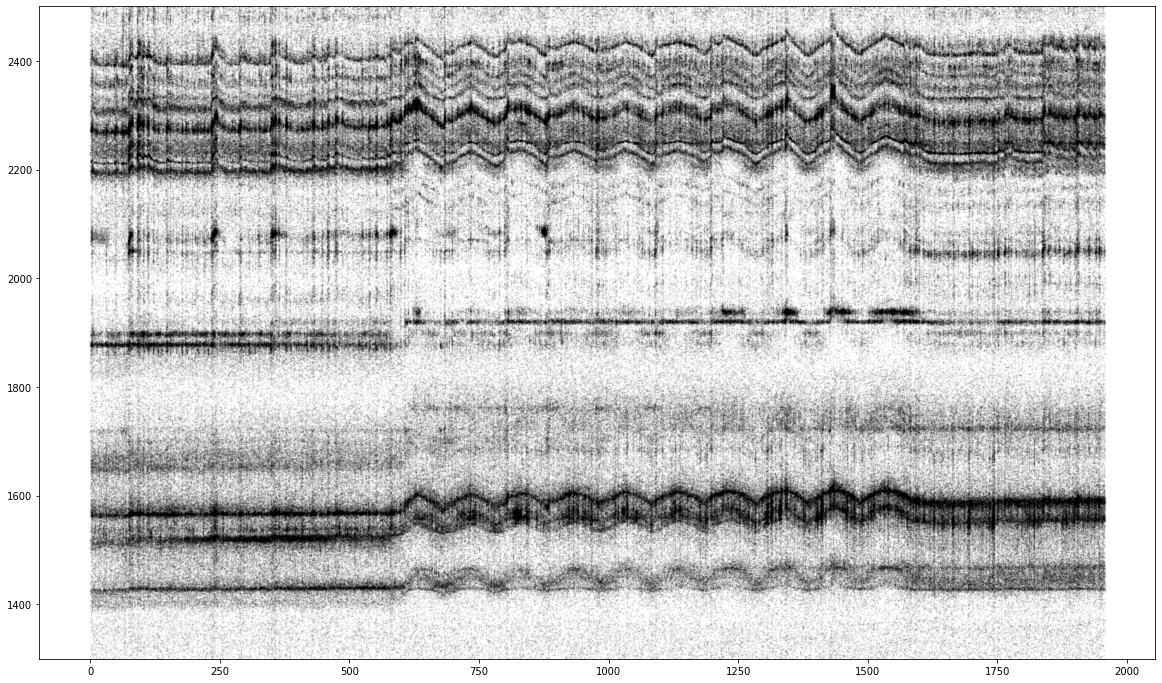

In [39]:
fig, ax = plt.subplots()
x = peaks['sample_ind'] / rec_preprocessed.get_sampling_frequency()
y = peak_locations['y']
ax.scatter(x, y, s=1, color='k', alpha=0.05)
ax.set_ylim(1300, 2500)

## conclusion

